In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive

In [2]:
#%%
from Modele_decodeur_maison import *

from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 50

# Images
# images = np.load("C:/Users/lucas/Desktop/train-resnet50-res4frelu.npy")

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 4 
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 196
dropout = 0.1
activation = nn.Softmax
embedding_dim = 196

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation).to(device)

model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation).to(device)


In [3]:
#%%
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map):
    model_en.eval()
    model_fr.eval()
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data),dim = 2).T[j].T
    return tensor_to_sentence(output.view(-1),inv_map)

i = np.random.randint(len(tokenized_en)//50)
j = np.random.randint(50)
data,target = get_batch(tokenized_en, i)

# print("Phrase à traduire : \n" + tensor_to_sentence(target.T[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr))


#%%

In [4]:
# import os

# import s3fs
# import pandas
# # Create filesystem object
# S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
# fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("work/ummt/tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("work/ummt/tordjx/val-resnet50-res4frelu.npy")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


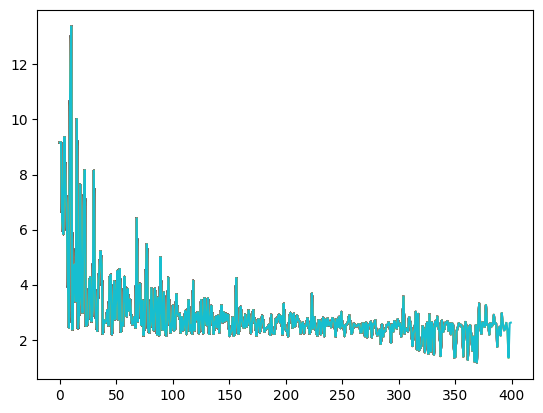

In [5]:
batchsz = 50
train_features_reshape= torch.from_numpy(train_features.reshape(train_features.shape[0]//batchsz ,batchsz,1024 , 196)).to(dtype = torch.float32)
train_data_fr = [tokenized_fr, train_features_reshape]
train_data_en = [tokenized_en, train_features_reshape]
# Y=train_auto_encoding(model_fr,tokenized_fr)
# Y=train_auto_encoding(model_en,tokenized_en)
# Y= cycle_consistency_train(model_fr,model_en,tokenized_fr,tokenized_en)
mixed_train(model_fr,model_en,train_data_fr,train_data_en,200,50, True)

